AUTO comparison:


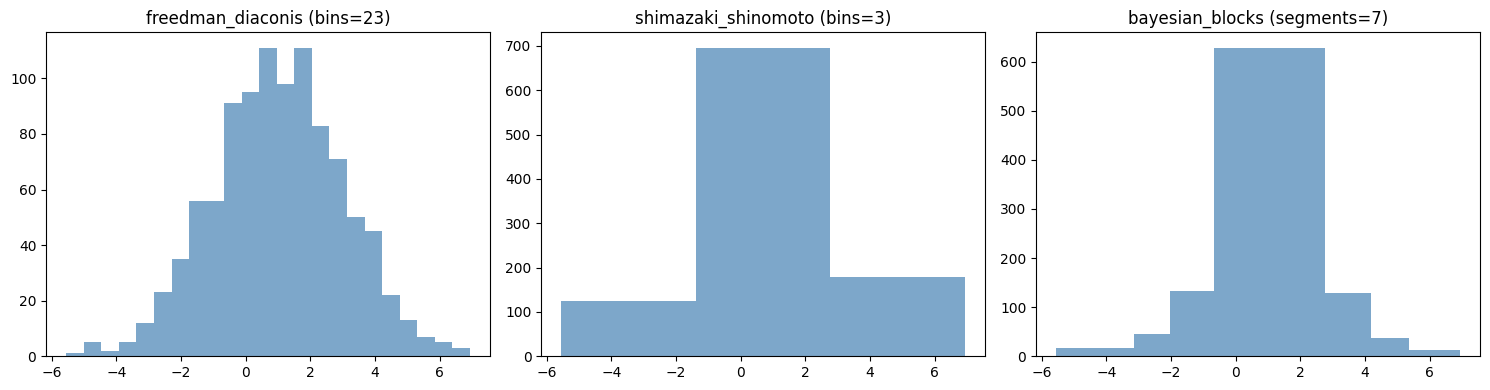

{'freedman_diaconis': 23, 'shimazaki_shinomoto': 3, 'bayesian_blocks': array([-5.55056111, -3.13815413, -2.02109845, -0.6727288 ,  2.77168007,
        4.18673387,  5.36384664,  6.93271938])}

BEST choice (via CV log-likelihood):
{'best': ('bayesian_blocks', array([-5.55056111, -3.13815413, -2.02109845, -0.6727288 ,  2.77168007,
        4.18673387,  5.36384664,  6.93271938]), -2.1056250876383995), 'all_scores': {'freedman_diaconis': -2.1462703011448196, 'shimazaki_shinomoto': -2.247916637597432, 'bayesian_blocks': -2.1056250876383995}}


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from astropy.stats import bayesian_blocks

# ================================================================
# Classical rules
# ================================================================
def freedman_diaconis_bins(x: np.ndarray) -> int:
    x = np.asarray(x)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    h = 2 * iqr * len(x) ** (-1/3)
    if h <= 0:
        return int(np.sqrt(len(x)))  # fallback
    return int(np.ceil((x.max() - x.min()) / h))

def shimazaki_shinomoto_bins(x: np.ndarray, min_bins: int = 2, max_bins: int = 100) -> int:
    x = np.asarray(x)
    N = len(x)
    bins_range = range(min_bins, max_bins+1)
    costs = []
    for k in bins_range:
        edges = np.linspace(x.min(), x.max(), k+1)
        counts, _ = np.histogram(x, edges)
        mean = counts.mean()
        var = counts.var()
        cost = (2 * mean - var) / (N**2)
        costs.append(cost)
    return bins_range[np.argmin(costs)]

# ================================================================
# Cross-validated log-likelihood scoring
# ================================================================
def _cv_loglik(x, bins_or_edges, n_splits=5):
    x = np.asarray(x)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_idx, test_idx in kf.split(x):
        x_train, x_test = x[train_idx], x[test_idx]

        if isinstance(bins_or_edges, int):  # fixed bin count
            edges = np.linspace(x.min(), x.max(), bins_or_edges+1)
        else:  # already edges (Bayesian Blocks)
            edges = bins_or_edges

        counts, _ = np.histogram(x_train, bins=edges)
        pdf = counts / counts.sum() / np.diff(edges)

        pdf = np.clip(pdf, 1e-12, None)  # avoid log(0)

        bin_idx = np.searchsorted(edges, x_test, side="right") - 1
        bin_idx = np.clip(bin_idx, 0, len(pdf)-1)

        ll = np.mean(np.log(pdf[bin_idx]))
        scores.append(ll)

    return np.mean(scores)

# ================================================================
# Manual Bayesian Blocks (faithful Scargle DP)
# ================================================================
def bayesian_blocks_manual(x, gamma=None):
    """
    Bayesian Blocks (Scargle et al. 2013) dynamic programming.
    Works for continuous 1D data.
    """
    x = np.sort(np.asarray(x))
    N = x.size

    # Default prior penalty (Scargle eq. 21)
    if gamma is None:
        gamma = 4 - np.log(73.53 * N ** -0.478)

    # Cumulative counts
    count_vec = np.arange(1, N + 1)
    # Differences for block widths
    edges = np.concatenate(([x[0]], 0.5 * (x[1:] + x[:-1]), [x[-1]]))

    # Arrays
    best = np.zeros(N, dtype=float)
    last = np.zeros(N, dtype=int)

    for i in range(N):
        # Vector of start indices
        j = np.arange(i + 1)

        # Count in block j..i
        k = count_vec[i] - np.concatenate(([0], count_vec[j[:-1]]))
        # Width of block
        T = x[i] - x[j]
        T[T <= 0] = 1e-12

        # Fitness
        fit_vec = k * (np.log(k) - np.log(T))

        # DP recurrence
        if i == 0:
            A = fit_vec - gamma
        else:
            A = best[j - 1] + fit_vec - gamma
            A[0] = fit_vec[0] - gamma

        last[i] = j[np.argmax(A)]
        best[i] = np.max(A)

    # Backtrack
    change_points = []
    i = N - 1
    while i > 0:
        cp = last[i]
        change_points.append(cp)
        i = cp - 1
    change_points = change_points[::-1]

    return edges[np.r_[0, change_points, N]]

# ================================================================
# Wrapper
# ================================================================
def optimal_binning(x: np.ndarray, method: str = "auto", plot: bool = True):
    results = {}

    if method in ("fd", "auto", "best"):
        results["freedman_diaconis"] = freedman_diaconis_bins(x)
    if method in ("ss", "auto", "best"):
        results["shimazaki_shinomoto"] = shimazaki_shinomoto_bins(x)
    if method in ("bb", "auto", "best"):
        results["bayesian_blocks"] = bayesian_blocks(x)

    if method == "best":
        scores = {name: _cv_loglik(x, val) for name, val in results.items()}
        best_name = max(scores, key=scores.get)
        return {"best": (best_name, results[best_name], scores[best_name]),
                "all_scores": scores}

    if plot:
        n_plots = len(results)
        plt.figure(figsize=(5*n_plots, 4))
        for i, (name, val) in enumerate(results.items(), 1):
            plt.subplot(1, n_plots, i)
            if name == "bayesian_blocks":
                plt.hist(x, bins=val, color="steelblue", alpha=0.7)
                plt.title(f"{name} (segments={len(val)-1})")
            else:
                plt.hist(x, bins=val, color="steelblue", alpha=0.7)
                plt.title(f"{name} (bins={val})")
        plt.tight_layout()
        plt.show()

    return results

# ================================================================
# Example
# ================================================================
if __name__ == "__main__":
    data = np.random.randn(1000) * 2 + 1
    print("AUTO comparison:")
    res = optimal_binning(data, method="auto", plot=True)
    print(res)

    print("\nBEST choice (via CV log-likelihood):")
    best = optimal_binning(data, method="best", plot=False)
    print(best)
